In [1]:
%%capture
!pip install catboost

In [2]:
from datetime import timedelta
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import holidays

color = sns.color_palette()

%matplotlib inline

In [3]:
# Загрузка файла
# from google.colab import files
# files.upload()

In [4]:
# Считаем данные в датафрейм и посмотрим на них
data_gist = 'https://gist.github.com/korerdev/bc7e8c7c0b7db5c920f8ff6fd0a05cc4/raw/5dc78d55082f1e9abce20de57dc099ad0ca1119f/gistfile1.txt'
df = pd.read_csv(data_gist, usecols=['date', 'time_interval', 'quantity'])
df['date'] = pd.to_datetime(df['date'])
data = df.copy()
df.head()

,date,time_interval,quantity
0,2022-09-01,0,16
1,2022-09-01,1,5
2,2022-09-01,2,5
3,2022-09-01,3,7
4,2022-09-01,4,3


# EDA

In [5]:
# Посмотрим на колонки, информацию о пустых значениях и типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10342 entries, 0 to 10341
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           10342 non-null  datetime64[ns]
 1   time_interval  10342 non-null  int64         
 2   quantity       10342 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 242.5 KB


In [6]:
# Сводные статистики по числовым переменным
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_interval,10342.0,12.010249,7.203823,0.0,6.0,12.0,18.0,24.0
quantity,10342.0,160.903210,128.813280,1.0,16.0,179.0,271.0,502.0


In [7]:
# Сводные статистики по датам
df.date.describe()

<ipython-input-7-e9eedcf9f581>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.date.describe()


count                   10342
unique                    415
top       2023-03-27 00:00:00
freq                       25
first     2022-09-01 00:00:00
last      2023-10-20 00:00:00
Name: date, dtype: object

In [8]:
# Посмотрим на уникальные значения по колнкам.
# Возник вопрос почему 25 интервалвалов?
df.nunique()

date             415
time_interval     25
quantity         459
dtype: int64

In [9]:
# Посмотрим на количество интервалов в сутках.
df_gr_date = df.groupby(df.date, as_index=False)['time_interval'].count()
df_gr_date

,date,time_interval
0,2022-09-01,24
1,2022-09-02,25
2,2022-09-03,25
3,2022-09-04,24
4,2022-09-05,24
...,...,...
410,2023-10-16,25
411,2023-10-17,25
412,2023-10-18,25
413,2023-10-19,25


In [10]:
# Получен ответ на вопрос.
# Нужно убрать 24ые интервалы и прибавить их значения к следующим.
df_gr_interval = df_gr_date.groupby('time_interval').agg('count').reset_index()
df_gr_interval

,time_interval,date
0,15,1
1,20,1
2,21,1
3,24,14
4,25,398


In [11]:
# Получим дни когда интервалов меньше 23.
# Что же произошло 23 января 2023 ?
df_gr_date[df_gr_date['time_interval'].isin([15, 20, 21])]

,date,time_interval
121,2022-12-31,20
122,2023-01-01,15
144,2023-01-23,21


In [12]:
# Пропала часть ночных интервалов
df.loc[df.date == '2023-01-23']

,date,time_interval,quantity
3576,2023-01-23,0,1
3577,2023-01-23,5,1
3578,2023-01-23,6,2
3579,2023-01-23,7,8
3580,2023-01-23,8,23
3581,2023-01-23,9,63
3582,2023-01-23,10,13
3583,2023-01-23,11,71
3584,2023-01-23,12,12
3585,2023-01-23,13,9


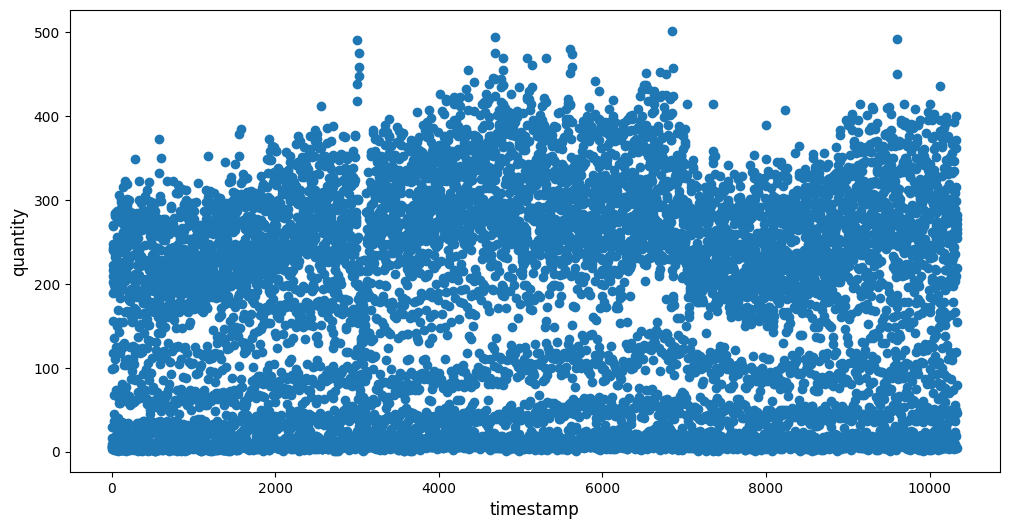

In [13]:
# Нарисуем график зависимости количества от даты
# Видим ряд закономерностей: рост перед праздниками, спад вовремя,
# а также продолжительный спад летом. Можем добавить в модель соответствующие признаки.
# Также просматривается сезонность, но длина ряда мала что бы быт уверенным в этом.
# Также видно, что ряд интервалов можно предсказывать константой.
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df.quantity)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('quantity', fontsize=12)
plt.show()

<Figure size 1200x800 with 0 Axes>

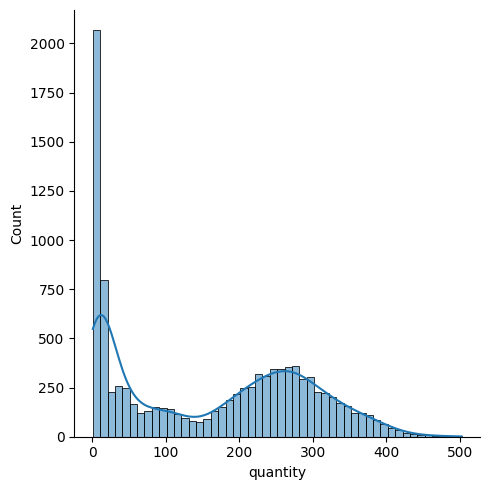

In [14]:
# Нарисуем распределение количества.
# Возможно, надо будет с этим поработать.
plt.figure(figsize=(12, 8))
sns.displot(df.quantity, bins=50, kde=True)
plt.xlabel('quantity')
plt.show()

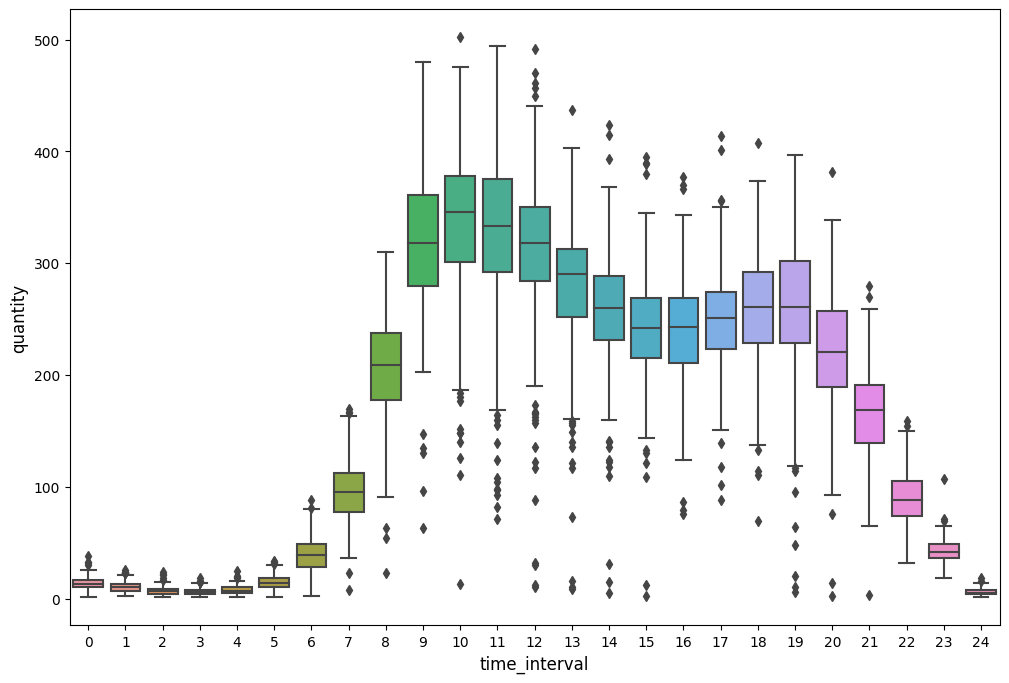

In [15]:
# Нарисуем боксплоты для количества по интервалам.
# Данные намекают нам на связь с активностью людей.
plt.figure(figsize=(12, 8))
sns.boxplot(x='time_interval', y='quantity', data=df)
plt.ylabel('quantity', fontsize=12)
plt.xlabel('time_interval', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()

In [16]:
# Добавим фичу Год-Месяц и построим боксплот.
df['year_month'] = df['date'].dt.year.astype(str) + df['date'].dt.strftime('%m')

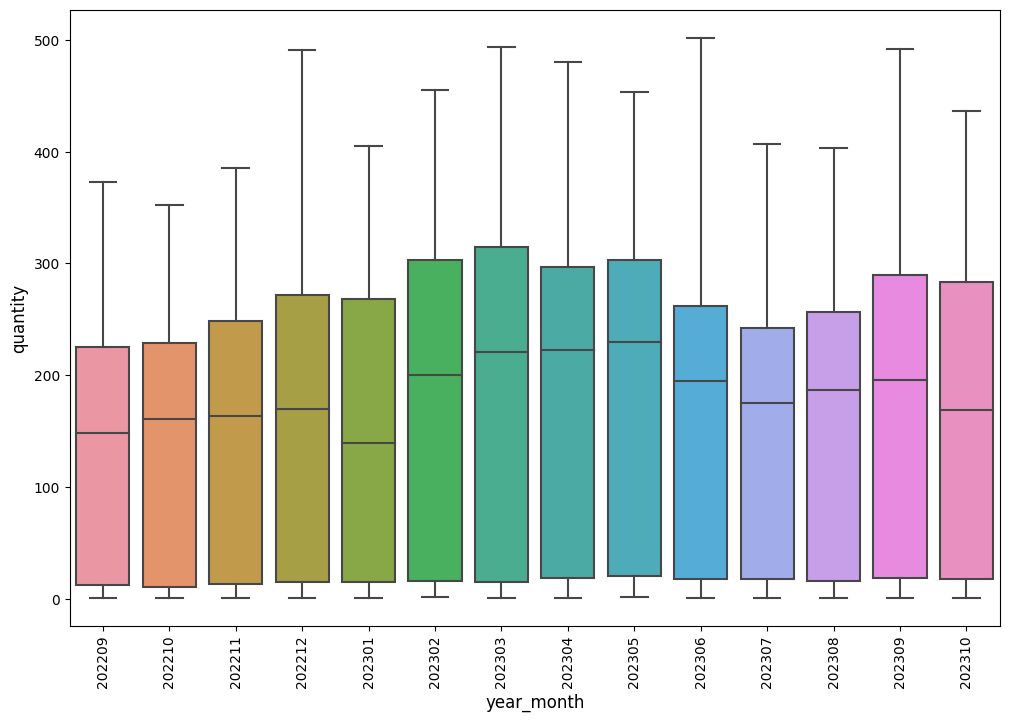

In [17]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='year_month', y='quantity', data=df)
plt.ylabel('quantity', fontsize=12)
plt.xlabel('year_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

<Axes: xlabel='year_month'>

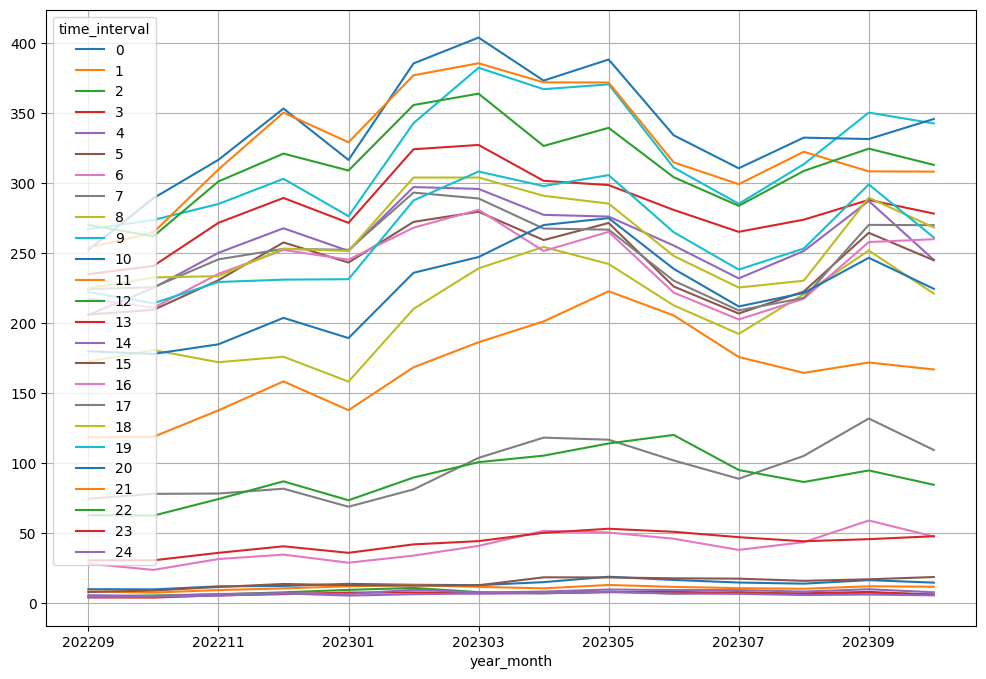

In [18]:
# Посмотрим динамику количества по времени.
# Часть интервалов постоянна.
# Остальная часть изменяется относительно одинаково.
dpivot = df.pivot_table(index='year_month', columns='time_interval', values='quantity', aggfunc='mean')
dpivot.plot(figsize=(12, 8), grid=True)

# Подготовка данных


In [19]:
# Создадим простые признаки.
def add_features(df):
    df.fillna(0, inplace=True)
    ru_holidays = holidays.country_holidays("RU")
    df['date'] = pd.to_datetime(df['date'])
    df['is_holiday'] = df['date'].map(lambda x: x in ru_holidays)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_month_end'] = df['date'].dt.is_month_end
    df['is_quarter_start'] = df['date'].dt.is_quarter_start
    df['is_quarter_end'] = df['date'].dt.is_quarter_end
    df['is_year_start'] = df['date'].dt.is_year_start
    df['is_year_end'] = df['date'].dt.is_year_end
    df['is_weekend'] = df['weekday'].isin([5, 6])
    df['is_friday'] = df['weekday'] == 4
    df['year_month'] = df['date'].dt.year.astype(str) + df['date'].dt.strftime('%m')

    df = df.drop('date', axis=1)

    # Приводим boolean к 0/1
    df = df.astype(float)

    return df

df = add_features(df)
df.head()

,time_interval,quantity,year_month,is_holiday,year,month,day,weekday,week_of_year,quarter,day_of_year,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,is_friday
0,0.0,16.0,202209.0,0.0,2022.0,9.0,1.0,3.0,35.0,3.0,244.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,5.0,202209.0,0.0,2022.0,9.0,1.0,3.0,35.0,3.0,244.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,5.0,202209.0,0.0,2022.0,9.0,1.0,3.0,35.0,3.0,244.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,7.0,202209.0,0.0,2022.0,9.0,1.0,3.0,35.0,3.0,244.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,202209.0,0.0,2022.0,9.0,1.0,3.0,35.0,3.0,244.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Избавляемся от 24 интервала и добавим значение в следующий 0 интервал.
df['quantity'] = np.where(df['time_interval'].shift() == 24, df['quantity'].shift() + df['quantity'], df['quantity'])
df.fillna(0, inplace=True)
df = df[df.time_interval != 24]

# Моделирование

In [21]:
# Разбиваем данные на трейн и тест.
train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)

pred_date = '2023-06-03'

# y = np.log(train['quantity'] + 1)
X = train.drop(['quantity'], axis=1)
y = train['quantity']

X_test = test.drop(['quantity'], axis=1)
y_test = test['quantity']

X_tr, X_val, y_tr, y_val = train_test_split(X, y, train_size=0.80, random_state=42)

## 1. Бейзлайн

Предсказываем значение интервала значением из того же интервала минус 2 дня.
Также можно немного улучшить и брать среднее за период.
С днями, которые содержат меньше интервалов, надо поработать: дополнить до 24 интервалов, либо удалить и в ручном режиме делать предсказания на основании прошлого года + поправка на тренд.

In [22]:
dd = data[['date', 'time_interval', 'quantity']]
dd['quantity'] = np.where(dd['time_interval'].shift() == 24, dd['quantity'].shift() + dd['quantity'], dd['quantity'])
dd = dd[dd.time_interval != 24]
dd['prev_q'] = dd.quantity.shift(48)
dd.fillna(0, inplace=True)
dd.loc[dd.date >= pred_date, ['date', 'time_interval', 'quantity', 'prev_q']]
dd[['quantity', 'prev_q']] = dd[['quantity', 'prev_q']].astype(int)
dd['delta'] = dd['quantity'] - dd['prev_q']
dd['abs_delta'] = np.abs(dd['quantity'] - dd['prev_q'])

mae = np.mean(dd['abs_delta'])
bias = np.mean(dd['delta'])

print('MAE = ', round(mae, 2))
print('bias = ', round(bias, 2))
print('Score = ', round(mae + abs(bias), 2))
dd.tail()

MAE =  28.62
bias =  0.86
Score =  29.49


,date,time_interval,quantity,prev_q,delta,abs_delta
10336,2023-10-20,19,271,302,-31,31
10337,2023-10-20,20,219,198,21,21
10338,2023-10-20,21,154,178,-24,24
10339,2023-10-20,22,79,74,5,5
10340,2023-10-20,23,46,38,8,8


## 2. Catboost
- Бустинги хорошо себя показывает в работе с рядами.
- Работает хорошо с базовыми настройками.
- Аналогичные библиотеки показывают примерно одинаковый результат.
- Количество данных небольшое и скорость обучения неважна.

In [23]:
n_splits = 10  # 3, 5, 10
clfs = []
scores = []

X = train.drop(['quantity'], axis=1)
y = train['quantity']

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train)
    eval_dataset = Pool(data=X_test, label=y_test)

    clf = CatBoostRegressor(
        depth=3,
        iterations=5000,
        # learning_rate=0.06,
        loss_function="MAE",
        custom_metric=["MAE"],

        # # Регуляризация и ускорение
        # colsample_bylevel=0.098,
        # subsample=0.95,
        # l2_leaf_reg=9,
        # min_data_in_leaf=243,
        # max_bin=187,
        # random_strength=1,

        # # Параметры ускорения
        # task_type="CPU",
        # thread_count=-1,
        # bootstrap_type="Bernoulli",

        random_seed=42,
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=200,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "MAE" in k], dtype="float16"))

assert len(clfs) == n_splits
print("Mean MAE score: ", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))


0:	learn: 110.5298564	test: 113.1218859	best: 113.1218859 (0)	total: 48.9ms	remaining: 4m 4s
200:	learn: 22.7839624	test: 21.9833190	best: 21.9833190 (200)	total: 349ms	remaining: 8.33s
400:	learn: 20.6227917	test: 19.8807403	best: 19.8807403 (400)	total: 645ms	remaining: 7.39s
600:	learn: 19.4345809	test: 18.9619584	best: 18.9611952 (599)	total: 956ms	remaining: 7s
800:	learn: 18.5642058	test: 18.3251881	best: 18.3251881 (800)	total: 1.26s	remaining: 6.6s
1000:	learn: 18.0265445	test: 17.9324066	best: 17.9324066 (1000)	total: 1.56s	remaining: 6.23s
1200:	learn: 17.5972899	test: 17.5614162	best: 17.5614162 (1200)	total: 2.07s	remaining: 6.55s
1400:	learn: 17.2698880	test: 17.2992283	best: 17.2992283 (1400)	total: 2.48s	remaining: 6.37s
1600:	learn: 17.0200396	test: 17.1067436	best: 17.1064767 (1599)	total: 2.95s	remaining: 6.26s
1800:	learn: 16.7664505	test: 16.8873478	best: 16.8872976 (1798)	total: 3.76s	remaining: 6.69s
2000:	learn: 16.5909947	test: 16.7654597	best: 16.7646272 (1998)

In [24]:
# Лучшие параметры модели из перебора
model = CatBoostRegressor(
    iterations=5000,
    random_seed=42,
    thread_count=-1,
    loss_function="MAE",
    eval_metric="MAE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X, y)

# Лучшие параметры модели из перебора
searched_params = randomized_search_result["params"]
searched_params

0:	learn: 161.4129192	test: 164.7378091	best: 164.7378091 (0)	total: 1.71ms	remaining: 8.55s
500:	learn: 28.6366349	test: 28.3687244	best: 28.3687244 (500)	total: 509ms	remaining: 4.57s
1000:	learn: 25.4868476	test: 25.5701674	best: 25.5701674 (1000)	total: 1.05s	remaining: 4.19s
1500:	learn: 24.4172143	test: 24.5878555	best: 24.5878555 (1500)	total: 1.56s	remaining: 3.63s
2000:	learn: 23.9701200	test: 24.2392959	best: 24.2392959 (2000)	total: 2.09s	remaining: 3.13s
2500:	learn: 23.7827119	test: 24.0935159	best: 24.0935159 (2500)	total: 2.58s	remaining: 2.58s
3000:	learn: 23.6541878	test: 23.9829061	best: 23.9829061 (3000)	total: 3.1s	remaining: 2.07s
3500:	learn: 23.5534088	test: 23.9031816	best: 23.9031816 (3500)	total: 3.62s	remaining: 1.55s
4000:	learn: 23.4784086	test: 23.8601105	best: 23.8600151 (3996)	total: 4.14s	remaining: 1.03s
4500:	learn: 23.4111426	test: 23.8250493	best: 23.8249472 (4496)	total: 4.65s	remaining: 515ms
4999:	learn: 23.3549447	test: 23.7934796	best: 23.79347

{'l2_leaf_reg': 2, 'depth': 4.0, 'one_hot_max_size': 2.0, 'learning_rate': 0.1}

In [25]:
# Обучим модель с "хорошими" параметрами для train и замерим качество на test
model = CatBoostRegressor(
    iterations=5000,
    random_seed=42,
    thread_count=-1,
    loss_function="MAE",
    eval_metric="MAE",
    verbose=500,
    **searched_params
)

model.fit(
    train.drop(['quantity'], axis=1),
    train['quantity'],
    verbose=False,
    plot=False)

pred = model.predict(test.drop(['quantity'], axis=1))
# pred = np.round((np.exp(pred) - 1))

mae = np.mean(np.abs(pred - test['quantity']))
bias = np.mean((pred - test['quantity']))

print('MAE = ', round(mae, 2))
print('bias = ', round(bias, 2))
print('Score = ', round(mae + abs(bias), 2))

MAE =  15.59
bias =  0.59
Score =  16.17


In [26]:
# Обучим модель на всех данных и сохраним в файл
model = CatBoostRegressor(
    iterations=5000,
    random_seed=42,
    thread_count=-1,
    loss_function="MAE",
    eval_metric="MAE",
    verbose=500,
    **searched_params
)

model.fit(
    df.drop(['quantity'], axis=1),
    df['quantity'],
    verbose=False,
    plot=False)

model.save_model("catboost_model.cbm", format="cbm")

# Пост анализ

Видим, что Catboost предсказывает лучше наивного предсказания. На будущее можно попробовать moving average интервала за последние n-дней. Можно попробовать инструменты-аналоги. Выбрать лучший. И заниматься его настройкой дальше.
Можно брать простые алгоритмы и на их ошибках обучать бустинг.
Ну и конечно целое поле для придумывания признаков. В этом примере использовал самые наивные. Надо, как минимум, попробовать учитывать суточные циклы. Наивные признаки очень слабые. Широкое поле для фантазии. Признак time_interval желательно "размыть" на основе составных признаков, так как алгоритм настраивается на него.
Также на будущее стоит попробовать семейство моделей ARIMA, библиотеку prophet.

Пару слов по выбору метрики. Мой выбор пал на MAE в основном потому, что она штрафует за большие ошибки меньше, чем та же RMSE(менее чувствительна к выбросам).

In [27]:
# Посмотрим на важность признаков.
model.get_feature_importance(prettified=True).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Feature Id,time_interval,day_of_year,year_month,week_of_year,weekday,day,quarter,month,is_weekend,is_holiday,year,is_friday,is_year_end,is_month_end,is_year_start,is_quarter_end,is_quarter_start,is_month_start
Importances,92.496011,2.811077,1.612219,0.871089,0.723987,0.550966,0.263734,0.211661,0.1669,0.101385,0.047203,0.035841,0.031884,0.02456,0.023073,0.016524,0.011886,0.0


In [28]:
# Получим ответ на задание и сделаем предсказание на 22-10-2023

target_df = pd.DataFrame({'date': pd.to_datetime(24 * ['2023-10-22']),
                         'time_interval': np.arange(0, 24)})

target_df = add_features(target_df)
predictions = model.predict(target_df)

pd.DataFrame({'date': pd.to_datetime(24 * ['2023-10-22']),
              'time_interval': np.arange(0, 24),
              'predictions': np.ceil(predictions)})

,date,time_interval,predictions
0,2023-10-22,0,27.0
1,2023-10-22,1,14.0
2,2023-10-22,2,7.0
3,2023-10-22,3,6.0
4,2023-10-22,4,6.0
5,2023-10-22,5,11.0
6,2023-10-22,6,29.0
7,2023-10-22,7,91.0
8,2023-10-22,8,217.0
9,2023-10-22,9,336.0
